In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
from operator import add
import collections
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
import gym

In [ ]:
'''IDEIA MUITO BOA

E SE A PONTUACAO DO JOGADOR NAO FOSSE APENAS A SOMA DOS PONTOS TOTAIS? WIN ABOVE AVERAGE OU ALGUMA OUTRA DESSAS METRICAS MANEIRAS DO BASEBALL,
ALGUMA COISA QUE SE UTILIZASSE TAMBEM DO DESV PAD DO CARA (E MELHOR UM CARA CONSTANTE OU UM QUE EXPLODE E MORRE? OU POSSO TER 2 QUE EXPLODEM
NO TIME DESDE QUE EU PREVEJA EXPLOSAO EM SEMANAS DIFERENTES? PROVAVELMENTE DEPENDE DO TAMANHO DA EXPLOSAO TBM)
'''

In [3]:
#importando base de jogadores
#agora ela vai ser uma base fake baseada no ano passado
#na hora do vamos ver, tem que ser a base desse ano
#essa base vai sendo alimentada com as escolhas da galera em tempo real

df_projs=pd.read_pickle('df_projs.pkl')
df_players=pd.read_pickle('df_players.pkl')

In [4]:
#trabalhando a base de projs
df=pd.read_pickle('df_projs.pkl')
df=df_projs[df_projs['season']==2021]
df=df.merge(df_players[['index', 'position', 'full_name']], how='left')
df=df[['index', 'position', 'full_name', 'pts_ppr']]
df['full_name']=np.where(df['full_name'].isna(), df['index'], df['full_name'])
#df=df[['index', 'pts_ppr']]
df=df.groupby(['index', 'position', 'full_name'], as_index=False)['pts_ppr'].sum()
#df=df.groupby(['index', 'position', 'full_name'])['pts_ppr'].sum()
df=df.sort_values('pts_ppr', ascending=False)
df['draft']=0

In [170]:
#salvando o df que sera modificado e retornado em csv
#df.to_csv('base_draft.csv', sep=";")

In [194]:
#lendo a base
df=pd.read_csv('base_draft.csv', sep=";")
df=df.sort_values('order')
df['pts_ppr']=df['pts_ppr']/400
df.head(2)

,Unnamed: 0,index,position,full_name,pts_ppr,draft,order,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
22,3722,6813,RB,Jonathan Taylor,0.7448,0,1,NaN,NaN,NaN,NaN,NaN,NaN
24,1773,4663,RB,Austin Ekeler,0.7368,0,2,NaN,NaN,NaN,NaN,NaN,NaN


A seguir, vamos criar o "state" atual, o input do algoritmo

In [6]:
#definindo as posicoes disponiveis
dict_positions={'QB':2, 'RB':3, 'WR':3, 'TE':2, 'FLEX':3, 'K':1, 'DEF':1}

#criando a funcao que, dada a posicao, vai selecionar o melhor jogador disponivel
def selecao(draft, pos):
    top_pos=draft[(draft['position']==pos) & (draft['draft']==0)].head(1)['index'].values[0]
    return top_pos

#criando a funcao que vai de fato selecionar os jogadores
def draft(draft, rooster, player_index, state):
    #draft[draft['index']==player_index]['draft']=1
    draft=draft.set_index('index')
    draft.loc[player_index,'draft']=1
    draft=draft.reset_index()
    rooster.append(player_index)
    pos=draft[draft['index']==player_index]['position'].values[0]
    if pos in ['RB', 'WR', 'TE'] and state[pos]<=0 and state['FLEX']>0:
        state['FLEX']= state['FLEX'] - 1
    else:
        state[pos]= state[pos] - 1

    return draft, rooster, state


#criando o current state
#vamos fazer um dict com os dados que precisamos
#primeiro, inicializar as posicoes
state=dict_positions.copy()
#criando variavel para determinar se eh ida ou volta do draft
state['ida']=1
#puxar o top 30 de cada posicao. Importante pro cara ter uma ideia de quem vai estar disponivel pra frente.
#esse dado na verdade vai estar em % vs media posicao, e % vs media de todas as posicoes, pra medir o valor do cara e da posicao
def get_state(dict_positions, df, state):
    media=df['pts_ppr'].mean()
    for pos in dict_positions:
        if pos=='FLEX':
            continue
        top_pos=df[(df['position']==pos) & (df['draft']==0)].copy()
        media_pos=top_pos['pts_ppr'].mean()
        i=0
        if pos in ['K', 'DEF']:
            limit=10
        else:
            limit=30
        #while i<limit:
        #    state[pos+'_'+str(i)+'_total']=top_pos.iloc[i]['pts_ppr']#/media
            #state[pos+'_'+str(i)+'_pos']=top_pos.iloc[i]['pts_ppr']/media_pos
        #    i=i+1
    #agora vamos transformar em um df
    df_state=pd.DataFrame(state, index=[0])
    return df_state


def init(df):
    dict_positions={'QB':2, 'RB':3, 'WR':3, 'TE':2, 'FLEX':3, 'K':1, 'DEF':1}
    state=dict_positions.copy()
    state['ida']=1
    df['draft']=0
    rooster=[]

    return dict_positions, state, df, rooster




In [7]:
#criando a funcao que vai computar o score do state
#o score vai ser composto pela soma das pontuacoes do time
#impacto negativo demais se faltar jogador de alguma posicao
#impacto bem negativo se tiver muitos jogadores da mesma posicao

def score(state, draft, rooster):
    positions=['QB', 'RB', 'WR', 'TE', 'FLEX', 'K', 'DEF']
    pontos=draft[draft['index'].isin(rooster)]['pts_ppr'].sum()
    falta=0
    sobra=0
    for pos in positions:
        if state[pos]>0:
            falta=falta+1
        elif state[pos]<0:
            sobra=sobra-1
    conta= pontos - 1000000*falta #- 1000*sobra
    return conta

Agora vamos montar a rede neural que vai rodar aqui e dar uma resposta

In [195]:
#montando a classe do jogo

from gym import spaces

class CustomEnv():
    def __init__(self):
        global df
        self.action_space=spaces.Discrete(6)
        self.options=['QB', 'RB', 'WR', 'TE', 'K', 'DEF']
        self.rooster=[]
        self.ida=1
        self.spaces=5
        self.qb=0
        self.rb=0
        self.wr=0
        self.te=0
        self.k=0
        self.de=0
        self.qb_max=2
        self.rb_max=3
        self.wr_max=3
        self.te_max=2
        self.k_max=1
        self.de_max=1
        self.flex_max=3
        self.rb_start=2
        self.wr_start=2
        self.te_start=1
        self.flex_start=3
        self.pts=0
        self.pts_debug=[]
        min=np.array([1,1,1,1,1,1])
        max=np.array([2,6,7,6,1,1])
        min=np.array([0,0,0,0,0,0])
        max=np.array([6,6,6,6,6,6])
        self.observation_space=spaces.Box(min,max)
        #self.state=min
        self.state=np.zeros(5)
        self.df=df
        self.lc=[]
        self.debug=[]

    def step(self, action):


        choice=self.options[action]

        
        #adicionando a simulacao dos outros players
        #por hora, eles so pegam os x melhores jogadores, independente da posicao
        #estou considerando que a IA e o ultimo a escolher de um total de 8 players
        df=self.df
        if self.ida==1:
            top = df[(df['draft']==0)].head(7)['index'].values
            df=df.set_index('index')
            for i in top:
                df.loc[i, 'draft']=1
            df=df.reset_index()
        else:
            a=1


        top_pos=df[(df['position']==choice) & (df['draft']==0)].head(1)['index'].values[0]
        pts=df[(df['position']==choice) & (df['draft']==0)].head(1)['pts_ppr'].values[0]

        df=df.set_index('index')
        df.loc[top_pos,'draft']=1
        df=df.reset_index()


        self.df=df
        self.rooster.append(top_pos)
        b=0
        if choice=='QB':
            
            if self.qb>=self.qb_max:
                factor=0
                b=1
            elif self.qb>=self.qb_max//2:
                factor=0.1
                b=2
            else:
                factor=1
                b=3
            self.qb=self.qb+1
            
        elif choice=='RB':
            if self.rb>=self.rb_max: #se eu completei os rb
                if self.flex_start>0: #se eu nao completei os flex
                    factor=1
                    b=4
                    self.flex_start=self.flex_start-1
                else: #else - se eu completei tambem os flex
                    factor=0
                    b=5
            elif self.rb_start<=0: #se eu completei os titulares
                if self.flex_start>0: #se eu nao completei os flex
                    factor=1
                    b=6
                    self.flex_start=self.flex_start-1
                else: #else - se eu completei tambem os flex
                    factor=0.1
                    b=7
            else: #else - se ainda falta rb titular
                factor=1
                b=8
                self.rb_start=self.rb_start-1
            self.rb=self.rb+1
            '''
            if self.rb>=self.rb_max and self.rb+self.wr+self.te >= self.flex_max+round(self.rb_max/2)+round(self.wr_max/2)+round(self.te_max/2):
                factor=0
            elif self.rb>=self.rb_max//2 and self.rb+self.wr+self.te>=self.rb_max//2+self.wr_max//2+self.te_max//2+self.flex_max:
                factor=0.1
            else:
                factor=1
            self.rb=self.rb+1
            '''
        elif choice=='WR':
            if self.wr>=self.wr_max: #se eu completei os rb
                if self.flex_start>0: #se eu nao completei os flex
                    factor=1
                    b=9
                    self.flex_start=self.flex_start-1
                else: #else - se eu completei tambem os flex
                    factor=0
                    b=10
            elif self.wr_start<=0: #se eu completei os titulares
                if self.flex_start>0: #se eu nao completei os flex
                    factor=1
                    b=11
                    self.flex_start=self.flex_start-1
                else: #else - se eu completei tambem os flex
                    factor=0.1
                    b=12
            else: #else - se ainda falta rb titular
                factor=1
                b=13
                self.wr_start=self.wr_start-1
            self.wr=self.wr+1
        elif choice=='TE':
            if self.te>=self.te_max: #se eu completei os rb
                if self.flex_start>0: #se eu nao completei os flex
                    factor=1
                    b=14
                    self.flex_start=self.flex_start-1
                else: #else - se eu completei tambem os flex
                    factor=0
                    b=15
            elif self.te_start<=0: #se eu completei os titulares
                if self.flex_start>0: #se eu nao completei os flex
                    factor=1
                    b=16
                    self.flex_start=self.flex_start-1
                else: #else - se eu completei tambem os flex
                    factor=0.1
                    b=17
            else: #else - se ainda falta rb titular
                factor=1
                b=18
                self.te_start=self.te_start-1
            self.te=self.te+1
        elif choice=='K':
            if self.k>0:
                factor=0
                b=19
            else:
                factor=1
                b=20
            self.k=self.k+1
        elif choice=='DEF':
            if self.de>0:
                factor=0
                b=21
            else:
                factor=1
                b=22
            self.de=self.de+1


        self.state[5-self.spaces]= (action+1)/6
        self.spaces=self.spaces-1

        self.pts = self.pts + factor * pts
        self.pts_debug.append(factor * pts)
        self.debug.append(b)

        self.ida=self.ida * -1

        #self.state[action]= self.state[action] + 1
        
    

        

        falta=np.array([self.qb, self.rb, self.wr, self.te, self.k, self.de])
        falta2=np.array([self.qb_max, self.rb_max, self.wr_max, self.te_max, self.k_max, self.de_max])
        falta=sum(falta2>falta)
        sobra=sum(falta>falta2)

        falta2= self.te + self.rb + self.wr - (self.te_max + self.rb_max + self.wr_max + self.flex_max)
        falta2=max(falta2,0)
        
        reward=(self.pts)#/20000# - 0.1 * falta - 0.1 * sobra
        #reward= factor * pts
        #print (falta)
        #print(reward)

        info={}

        if self.spaces==0:
            done=True
            self.lc.append(reward)
        else:
            done=False

        return self.state, reward, done, info

    def reset(self):
        
        self.rooster=[]
        self.ida=1
        self.spaces=5
        self.qb=0
        self.rb=0
        self.wr=0
        self.te=0
        self.k=0
        self.de=0
        self.rb_start=2
        self.wr_start=2
        self.te_start=1
        self.flex_start=3
        self.pts=0
        self.pts_debug=[]
        self.debug=[]
        #self.state=np.zeros(6)
        self.state=np.zeros(5)
        self.df['draft']=0

        return self.state



In [196]:
env = CustomEnv()

episodes = 20 #20 shower episodes
for episode in range(1, episodes+1):
    env.reset()
    done = False
    score = 0 
    
    while not done:
        action = random.randint(0,5)
        state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))

c:\Users\Carlos Magno\AppData\Local\Programs\Python\Python37\lib\site-packages\gym\spaces\box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode:1 Score:11.3466
Episode:2 Score:8.846375
Episode:3 Score:4.6434999999999995
Episode:4 Score:9.776525000000001
Episode:5 Score:7.87185
Episode:6 Score:9.471675000000001
Episode:7 Score:8.348425
Episode:8 Score:8.4908
Episode:9 Score:2.9050000000000002
Episode:10 Score:6.004475
Episode:11 Score:6.517025
Episode:12 Score:9.091425000000001
Episode:13 Score:9.506425
Episode:14 Score:5.72088
Episode:15 Score:10.321225000000002
Episode:16 Score:10.652225000000001
Episode:17 Score:10.040675
Episode:18 Score:8.24535
Episode:19 Score:7.878285
Episode:20 Score:9.082025000000002


In [212]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_normal, Zeros

In [198]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.callbacks import ModelIntervalCheckpoint, FileLogger

In [213]:
states = env.observation_space.shape
actions = env.action_space.n

def build_model(states, actions):
    model = Sequential()    
    model.add(Dense(24, activation='relu', input_shape=(1,5), kernel_initializer=he_normal()))
    model.add(Dense(24, activation='relu', kernel_initializer=he_normal()))
    #model.add(Dense(12, activation='relu'))
    model.add(Flatten())
    model.add(Dense(actions, activation='linear', kernel_initializer=Zeros()))
    return model

model = build_model(states, actions)
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 1, 24)             144       
                                                                 
 dense_28 (Dense)            (None, 1, 24)             600       
                                                                 
 flatten_9 (Flatten)         (None, 24)                0         
                                                                 
 dense_29 (Dense)            (None, 6)                 150       
                                                                 
Total params: 894
Trainable params: 894
Non-trainable params: 0
_________________________________________________________________


In [214]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy() 
    #policy = EpsGreedyQPolicy(eps=0.9)
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)#, batch_size=16) #target_model_update=1e-2) tem batch_size aqui tbm
    return dqn

def build_callbacks(env_name):
    #checkpoint_weights_filename = 'weights/dqn_' + env_name + '_weights_{step}.h5f'
    log_filename = 'dqn_{}_log.json'.format(env_name)
    #callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=1000)]
    callbacks = [FileLogger(log_filename, interval=100)]
    return callbacks


In [225]:
%%capture

callbacks = build_callbacks('env')
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-2, clipnorm=1.0), metrics=['mse'])
dqn.fit(env, nb_steps=60000, visualize=False, verbose=1, callbacks=callbacks)

In [ ]:
results = dqn.test(env, nb_episodes=1, visualize=False)
print(np.mean(results.history['episode_reward']))

Testing for 1 episodes ...
Episode 1: reward: 5.736, steps: 5
5.736220000000001


In [ ]:
print(env.state)
print(env.pts_debug)
#print(env.debug)

[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
[1.0636, 0.10455500000000001, 0.0, 0.0, 0.0]


In [ ]:
#df_players[df_players['index'].isin(env.rooster)][['full_name', 'fantasy_positions']]
df_rooster=pd.DataFrame(env.rooster, columns=['id']).reset_index()
df_players.merge(df_rooster, left_on='index', right_on='id', how='inner').sort_values('index_y')[['full_name', 'fantasy_positions']]

,full_name,fantasy_positions
2,Josh Allen,[QB]
0,Patrick Mahomes,[QB]
4,Justin Herbert,[QB]
1,Matthew Stafford,[QB]
3,Dak Prescott,[QB]


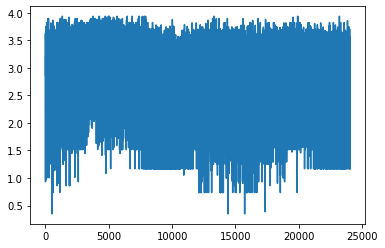

In [ ]:
plt.plot(env.lc)

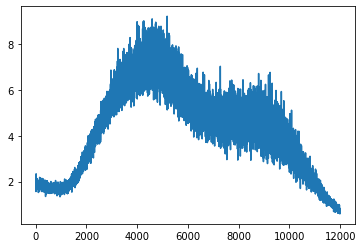

In [ ]:
import json
f=open('dqn_env_log.json')
a=json.load(f)

a.keys()
plt.plot(a['loss'])

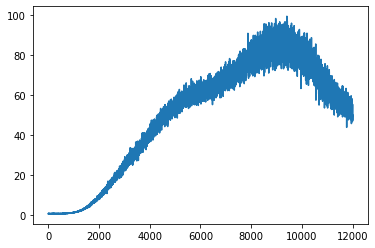

In [ ]:
plt.plot(a['mse'])

In [ ]:
#a=np.array([3,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
a=np.array([1,0,0,0,0])
dqn.model.predict(a.reshape(1,1,5))

array([[11.350141 , 10.286237 ,  9.747831 ,  9.265288 ,  8.7476425,
         8.508801 ]], dtype=float32)

In [ ]:
#FAZ TODAS AS SELECOES SEGUINDO O LOOP NORMAL
#GUARDA OS STATES DE CADA SELECAO
#MAS CALCULA APENAS O SCORE FINAL
#AI SO NO FINAL DO LOOP FAZ A ETAPA DE TREINO, PEGANDO ESSE MESMO VALOR DE REWARD FINAL E JOGANDO PARA TODOS OS STATES
#ACHO QUE PRECISO ADICIONAR A VAR DE QUANTAS ESCOLHAS FALTAM. MAS NAO TENHO CERTEZA

In [ ]:
#state -> vagas para cada posicao; top n de cada posicao; picks a fazer; escolhas ate a proxima
#decisao -> qual posicao pegar (da pra adicionar depois qual rank de qual posicao pegar)
#score -> pontuacao dos jogadores; penalidade absurda se nao preencher todas as posicoes; penalidade se pegar mais de 2 reservas da poiscao (ou mais de 1?)